In [1]:
#from IPython.core.debugger import set_trace
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
#Custom library
from __future__ import print_function

import os
import sys
sys.path.append("../Qiskit_Dynamic_Modelling")
sys.path.append("./modelQ")
sys.path.append("./dynamicsQ")

from visualize import *
from ode_solver import *
#from network import *
from dataloader import *
from lagrangian import *

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.utils.data
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
#from torchsummary import summary

from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.circuit.random import random_circuit
from qiskit import transpile, assemble

In [3]:
print("--- Loading training and test data... ---")
train_data = np.load('train_dataset.npz')
train_inputs = train_data["input"]
train_labels = train_data["labels"]

train_dataset = DynamicsDataset(train_inputs, train_labels)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=1,
                                                 shuffle=True,
                                                 collate_fn=DynamicsDataset.collate_fn,
                                                 pin_memory=True,
                                                 num_workers=1)
test_data = np.load('val_dataset.npz')
test_inputs = train_data["input"]
test_labels = train_data["labels"]
test_dataset = DynamicsDataset(test_inputs, test_labels)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 collate_fn=DynamicsDataset.collate_fn,
                                                 pin_memory=True,
                                                 num_workers=1)
print("--- Loading training and test data completed ---")

--- Loading training and test data... ---
--- Loading training and test data completed ---


In [4]:
for (X_train, y_train) in train_dataloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    print('X_train:', X_train)
    print('y_train:', y_train)
    break

for (X_test, y_test) in test_dataloader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    print('X_test:', X_test)
    print('y_test:', y_test)
    break

X_train: torch.Size([1, 4]) type: torch.DoubleTensor
y_train: torch.Size([1, 4]) type: torch.DoubleTensor
X_train: tensor([[-1.1970, -1.1259, -0.0436,  0.2298]], dtype=torch.float64)
y_train: tensor([[-0.0436,  0.2298,  9.3889, -0.5102]], dtype=torch.float64)
X_test: torch.Size([1, 4]) type: torch.DoubleTensor
y_test: torch.Size([1, 4]) type: torch.DoubleTensor
X_test: tensor([[ 1.9537,  0.2797, -0.0780, -0.2268]], dtype=torch.float64)
y_test: tensor([[-0.0780, -0.2268, -9.3138, -3.6618]], dtype=torch.float64)


In [5]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        #set_trace()
        #print('cRun:',thetas)
        List = [thetas]
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in List])
        #set_trace()
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

/opt/conda/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


Expected value for rotation pi [0.91]


/opt/conda/lib/python3.8/site-packages/sympy/core/expr.py:3949: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


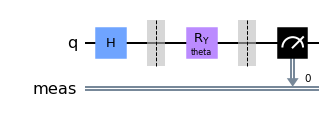

In [9]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(1, simulator, 100)
#data = [2.1757166385650635]
print('Expected value for rotation pi {}'.format(circuit.run(2.1757166385650635)))
#print('Expected value for rotation pi {}'.format(circuit.run([1.4173])))
circuit._circuit.draw()

In [10]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        #print('hFor:', input)
        #print('hFor1:', input[0])
        #print('hFor2:', input[0].tolist())
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        #print('3',input)
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [26]:
class LagrangianNeuralNetwork(torch.nn.Module):
    def __init__(self, D_in, hidden_list, D_out):
        """
        Neural Network used to approximate a paramaterized system lagrangian
        """
        super(LagrangianNeuralNetwork, self).__init__()
        self.model_layers = torch.nn.ModuleList()

        # input layer
        self.model_layers.append(torch.nn.Linear(D_in, hidden_list[0]))
        # self.model_layers.append(torch.nn.BatchNorm1d(hidden_list[0]))
        self.model_layers.append(torch.nn.Softplus())
        #self.model_layers.append(Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2))
        # add all hiden layers
        for i in range(1, len(hidden_list)):
            self.model_layers.append(torch.nn.Linear(hidden_list[i-1], hidden_list[i]))
            # self.model_layers.append(torch.nn.BatchNorm1d(hidden_list[i]))
            self.model_layers.append(torch.nn.Softplus())

        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)
        #self.model_layers.append(Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2))
        # output layer
        self.model_layers.append(torch.nn.Linear(hidden_list[-1], D_out))
        self.model_layers.append(torch.nn.Softplus())

    def forward(self, x):
        """
        applies all of the model layers, and returns the single output value,
        which in this case is the lagrangian of the system, representing the
        total energy
        """
        #print("2 ", x)
        for layer in self.model_layers:
            #print(len(self.model_layers))
            x = layer(x)
            #x = self.hybrid(x)
        #print('pH', x)                
        x = self.hybrid(x)
        return x

In [27]:
# determine device
print("--- Checking for CUDA Device... ---")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

--- Checking for CUDA Device... ---


In [28]:
# organize data
input_size = train_inputs.shape[1]
output_size = 1  # for all lagrangian systems, output should be just a scalar energy value

# build model
print("--- Constructing Model... ---")
D_in = input_size  # state size
# hidden_list = [D_in, 256, 256, 256, 256, 256]
hidden_list = [D_in, 32, 64, 128, 256, 512, 256, 128, 64, 32]
D_out = output_size
lnn_model = LagrangianNeuralNetwork(D_in, hidden_list, D_out)
#summary(lnn_model, (1, 28, 28), device='cpu')
# set up training parameters
learning_rate = 1e-4
weight_decay = 1e-5
momentum = 0.9
num_epochs = 20
optimizer = torch.optim.Adam(lnn_model.parameters(),
                             lr=learning_rate,
                             weight_decay=weight_decay)

if os.path.isfile("model_weights.pth"):
    print("Re-loading existing weights!")
    checkpoint = torch.load("model_weights.pth")
    lnn_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# ensure model is in train mode so gradients are properly calculated
lnn_model.train()
# load device to either GPU or CPU depending on hardware
lnn_model.to(device)

# set up loss function
loss_fcn = torch.nn.MSELoss()

# set up GradScaler to improve run speed
scaler = torch.cuda.amp.GradScaler()

print("--- Beginning Training! ---")
loss_list = []
lnn_model.train()
for epoch in range(num_epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        for p in lnn_model.parameters(): p.grad = None
        # Forward pass
        #output = model(data)
        # Calculating loss
        #loss = loss_func(output, target)
        # output from model is the energy calculated from the parameterized lagrangian
        #print('1',data)
        data = torch.squeeze(data)
        with torch.cuda.amp.autocast():
            target_pred = solve_euler_lagrange(lnn_model.forward, data.float())
            loss = loss_fcn(target_pred.unsqueeze(0), target.float())
        # Backward pass
        scaler.scale(loss).backward()
        # Optimize the weights
        scaler.step(optimizer)
        #print("Iter Num: ", batch_idx)
        if (batch_idx == 10):
            #print("Iter Num: ", batch_idx)
            break
        #print("Iter Num: ", len(train_dataloader))
        #print("Iter Num: ", batch_idx)
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / num_epochs, loss_list[-1]))

print('end')

--- Constructing Model... ---
Re-loading existing weights!
--- Beginning Training! ---


/tmp/ipykernel_59/3987841601.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: 9.8039
Training [10%]	Loss: 10.8552
Training [15%]	Loss: 17.0065
Training [20%]	Loss: 12.2205
Training [25%]	Loss: 13.8971
Training [30%]	Loss: 16.7136
Training [35%]	Loss: 21.4360
Training [40%]	Loss: 15.0806
Training [45%]	Loss: 13.7896
Training [50%]	Loss: 19.9014
Training [55%]	Loss: 13.5810
Training [60%]	Loss: 10.1830
Training [65%]	Loss: 17.6155
Training [70%]	Loss: 17.3491
Training [75%]	Loss: 16.5498
Training [80%]	Loss: 15.1826
Training [85%]	Loss: 12.5587
Training [90%]	Loss: 17.3735
Training [95%]	Loss: 23.4242
Training [100%]	Loss: 19.9395
end


Text(0, 0.5, 'Neg Log Likelihood Loss')

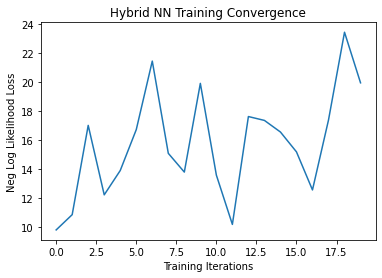

In [29]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')